In [2]:
import os
import io
import string
from tqdm import tqdm
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import tarfile
import requests
from io import BytesIO

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
response = requests.get(url)

with tarfile.open(fileobj=BytesIO(response.content), mode="r:gz") as tar:
    tar.extractall(path="tarextract")

This code sets up the project environment by importing essential libraries for file handling, data manipulation, and text processing. It uses tools like NLTK for natural language processing, TensorFlow/Keras for building and training neural networks, and scikit-learn for data splitting. Additionally, it includes visualization libraries to explore the data and downloads a compressed movie review dataset from Stanford, which it then extracts for further analysis.

### Read data

In [3]:
data_dir = "tarextract/aclImdb"

# Function to load reviews from a folder (pos/neg)
def load_reviews(directory, label):
    reviews = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), "r", encoding="utf-8") as file:
            reviews.append((file.read(), label))
    return reviews

# Load positive and negative reviews from train and test folders
pos_reviews = load_reviews(os.path.join(data_dir, "train/pos"), 1) + load_reviews(os.path.join(data_dir, "test/pos"), 1)
neg_reviews = load_reviews(os.path.join(data_dir, "train/neg"), 0) + load_reviews(os.path.join(data_dir, "test/neg"), 0)

# Combine into a single dataframe
df = pd.DataFrame(pos_reviews + neg_reviews, columns=["review", "sentiment"])

df.head()  # Preview the dataset

,review,sentiment
0,"I consider this movie a masterpiece, but it to...",1
1,Christina Raines plays a lovely model in New Y...,1
2,I reached the end of this and I was almost sho...,1
3,This is not the typical Mel Brooks film. It wa...,1
4,"I always follow the Dakar, so when my husband ...",1


We create a helper function to load text reviews and label them (1 for positive, 0 for negative). It then applies the function to both the training and test datasets for positive and negative reviews, combining them into a single pandas DataFrame for further analysis.

In [4]:
# Shuffle the DataFrame
shuffled_data = df.sample(frac=1, random_state=2023)

train_size = 0.8  # 80% for training, 20% for testing
train_data, test_data = train_test_split(shuffled_data, train_size=train_size, random_state=2023)

In [5]:
print(f'Train shappe: {train_data.shape}')
print(f'Test shappe: {test_data.shape}')

Train shappe: (40000, 2)
Test shappe: (10000, 2)


In [6]:
X_train = train_data['review']
y_train = train_data['sentiment']

X_test = test_data['review']
y_test = test_data['sentiment']

Then we shuffle the dataset to randomize the order of reviews and then splits it into training and testing sets using an 80/20 ratio. It prints out the sizes of these sets and separates the review texts and sentiment labels into distinct variables, preparing them for further model training and evaluation.

### Preprocessing - Clean text
* Remove stopwords
* Remove punctuations
* Remove html tags

In [7]:
# using stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
table = str.maketrans('', '', string.punctuation)

In [9]:
X_train_cleaned = []

for item in tqdm(X_train):
    sentence = str(item).lower()
    # if we have 2 joined words
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    # remove <br> tag
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    # remove stop words and punctuations
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table) # remove all punctuations
        if word not in stop_words:
            filtered_sentence += word + ' '

    X_train_cleaned.append(filtered_sentence.strip())

100%|██████████| 40000/40000 [00:25<00:00, 1578.76it/s]


This section first downloads NLTK's English stopwords and creates a translation table to remove punctuation. Then, it processes each training review by converting the text to lowercase, spacing out certain punctuation marks, and removing any HTML tags. Finally, it filters out punctuation and stopwords from each word, resulting in a cleaned version of the review text that's stored for later use.

### See sentences length distribution

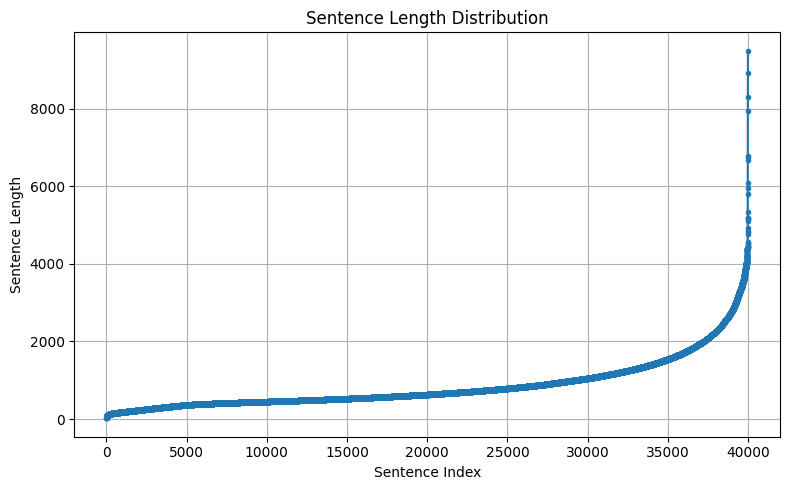

In [10]:
sentence_lengths = [len(sentence) for sentence in X_train_cleaned]
sorted_lengths = sorted(sentence_lengths)

x_values = list(range(1, len(X_train_cleaned) + 1))

# Creiamo il grafico
plt.figure(figsize=(8, 5))
plt.plot(x_values, sorted_lengths, marker='.', linestyle='-')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Length')
plt.grid(True)
plt.tight_layout()
plt.show()

### Zoom on the left part

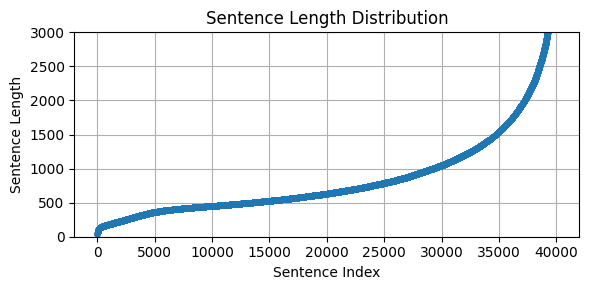

In [11]:
# Creiamo il grafico
plt.figure(figsize=(6, 3))
plt.plot(x_values, sorted_lengths, marker='.', linestyle='-')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Length')
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 3000)
plt.show()

**most of the sentences have less than 2000 words and 1000 words**

This section computes the character lengths of the cleaned reviews, sorts these lengths, and then visualizes the distribution with two line plots. The first plot displays the overall distribution of review lengths, while the second zooms in on reviews with lengths between 0 and 3000 characters, revealing that most reviews are relatively short—with many having fewer than 2000 or even 1000 characters.

### Check the total set of words

In [12]:
all_words = [word for sentence in X_train_cleaned for word in sentence.split()]

# Calculate the vocabulary size (number of unique words)
total_vocab_size = len(set(all_words))

print("Total Vocabulary Size:", total_vocab_size)

Total Vocabulary Size: 109842


Here is a list of all words from the cleaned training reviews by splitting each sentence into words. It then calculates the vocabulary size by counting the unique words in that list and prints the total, which in this case is 109,842.

### Tokenization

In [13]:
vocab_size = 50000
max_length = 2000
trunc_type='post'
padding_type='post'
oov_tok = ""

In [14]:
# Create a tokenizer with a maximum vocabulary size and an out-of-vocabulary token
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# Fit the tokenizer on the cleaned training texts to build the vocabulary
tokenizer.fit_on_texts(X_train_cleaned)

In [15]:
# Retrieve the mapping of words to their integer indices
word_index = tokenizer.word_index
# Convert the training texts into sequences of integer tokens
training_sequences = tokenizer.texts_to_sequences(X_train_cleaned)
# Pad or truncate the training sequences to the specified maximum length
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# Convert the testing texts into sequences of integer tokens
testing_sequences = tokenizer.texts_to_sequences(X_test)
# Pad or truncate the testing sequences to the specified maximum length
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

This code prepares text data for neural network input by tokenizing and padding it. It sets a vocabulary limit of 50,000 words and a maximum sequence length of 2000 tokens, using post-padding and post-truncation. Post-padding means adding extra tokens (usually zeros) to the end of a sequence when it's shorter than the desired length, while post-truncation means cutting off tokens from the end of a sequence that exceeds that length. A Keras Tokenizer is then created and fitted on the cleaned training reviews to build a word index. Both the training and testing texts are converted into sequences of integers based on this index, and then padded to ensure all sequences have a uniform length for model training.

### WordCloud

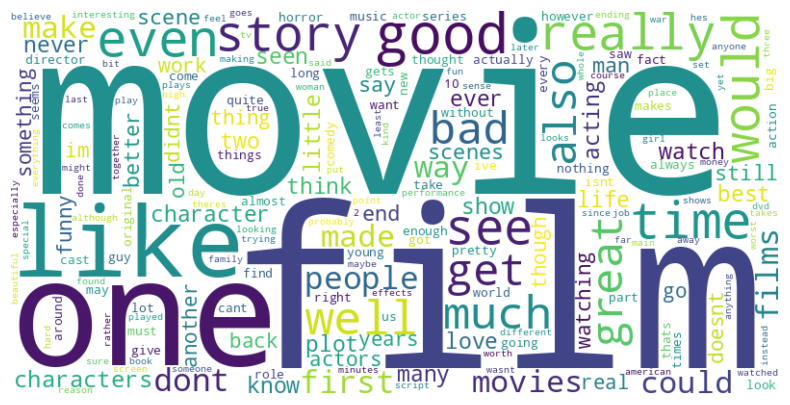

In [16]:
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud
word_counts = tokenizer.word_counts
wordcloud.generate_from_frequencies(word_counts)
wordcloud.to_file("header.png")

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

seems we have done a good cleaning

This code generates a word cloud from the tokenized word frequencies. The word cloud also serves as a visual check on the cleaning process: if the preprocessing was effective, you'll see meaningful, context-relevant words rather than common stopwords or unwanted symbols.

### Split the train into train and validation
Using 80% for train and 20% for test

In [17]:
# Split the padded training data and corresponding labels into training and validation sets (80/20 split)
training_padded, validation_padded, y_train, y_valid = train_test_split(training_padded, y_train, test_size=0.2, random_state=2023)

In [18]:
# Convert to numpy arrays for model compatibility
training_padded = np.array(training_padded)
training_labels = np.array(y_train)

validation_padded = np.array(validation_padded)
validation_labels = np.array(y_valid)

testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

In [19]:
print(f'Train shappe: {train_data.shape}')
print(f'Validation shappe: {validation_padded.shape}')
print(f'Test shappe: {test_data.shape}')

Train shappe: (40000, 2)
Validation shappe: (8000, 2000)
Test shappe: (10000, 2)


This code further splits the padded training data and labels into training and validation sets using an 80/20 split. It then converts the training, validation, and testing data—both sequences and labels—into numpy arrays for compatibility with TensorFlow models. Finally, it prints the shapes of the training, validation, and testing datasets to verify that the data is correctly partitioned for subsequent model training and evaluation.

### Define the neural network

In [20]:
embedding_dim = round(vocab_size ** 0.25) # use the fourth root of the vocab size
l2_regularization = 0.01 # tends to amplify differences between nonzero values and zero or close-tozero ones

In [21]:
def create_model(vocab_size, embedding_dim, max_length):
   # Define the input layer with a fixed sequence length
    input_layer = tf.keras.layers.Input(shape=(max_length,))
 # Create an embedding layer that converts word indices into dense vector representations
    embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

    # 🔥 More powerful feature extraction
    # Apply a 1D convolution to extract local features from the embeddings
    conv_layer = tf.keras.layers.Conv1D(64, 5, activation='relu', padding='same')(embedding_layer)
    # Use global max pooling to reduce the convolution output to a fixed-size vector by taking the maximum value from each feature map
    pooled_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)

# Normalize the pooled features to stabilize and speed up training
    batch_norm_1 = tf.keras.layers.BatchNormalization()(pooled_layer)

# Add a dense layer with 128 neurons and L2 regularization to learn higher-level features
    dense_layer_1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(batch_norm_1)
     # Apply dropout to reduce overfitting by randomly disabling 50% of the neurons during training
    dropout_layer_1 = tf.keras.layers.Dropout(0.5)(dense_layer_1)  # 🔥 Increase dropout

# Add a second dense layer with 64 neurons for further feature refinement
    dense_layer_2 = tf.keras.layers.Dense(64, activation='relu')(dropout_layer_1)
     # Normalize the output of the second dense layer
    batch_norm_2 = tf.keras.layers.BatchNormalization()(dense_layer_2)

 # Apply a second dropout layer with 40% dropout rate to further mitigate overfitting
    dropout_layer_2 = tf.keras.layers.Dropout(0.4)(batch_norm_2)

 # Define the output layer with a single neuron using sigmoid activation for binary classification
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_layer_2)

   # Create the model by specifying the input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

 # Compile the model with the Adam optimizer (using a higher learning rate) and binary crossentropy loss function
    adam = tf.keras.optimizers.Adam(learning_rate=0.001)  # 🔥 Higher LR
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [22]:
model = create_model(vocab_size, embedding_dim, max_length)
# Display the model's architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 2000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 2000, 15)            │         750,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 2000, 64)            │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 772,017 (2.95 MB)

 Trainable params: 771,761 (2.94 MB)

 Non-trainable params: 256 (1.00 KB)

In [23]:
checkpoint_path = "training/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [24]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_freq=5  # Save every 5 epochs
)
# Create a ModelCheckpoint callback to save the model weights during training
# - save_weights_only=True: Only the model's weights are saved, not the full model architecture.
# - verbose=1: Prints out messages when the model is saved.
# - save_freq=5: Saves the model weights every 5 epochs.

In [25]:
from sklearn.utils.class_weight import compute_class_weight
# Compute class weights using the training labels to balance the classes during training
class_weights = compute_class_weight('balanced', classes=np.unique(training_labels), y=training_labels)
# Convert the computed class weights into a dictionary format (mapping class index to weight)
class_weights_dict = dict(enumerate(class_weights))

In [26]:
history = model.fit(
    training_padded,
    training_labels,
    epochs=2,
    validation_data=(validation_padded, validation_labels),
    class_weight=class_weights_dict,
    verbose=2
)

# Train the model using the padded training data and labels
# - epochs=2: The model will train for 2 epochs.
# - validation_data: Provides validation data to monitor model performance.
# - class_weight: Applies the computed class weights to help balance the training.
# - verbose=2: Provides more concise output during training.

Epoch 1/2
1000/1000 - 112s - 112ms/step - accuracy: 0.6787 - loss: 0.9874 - val_accuracy: 0.8444 - val_loss: 0.4569
Epoch 2/2
1000/1000 - 145s - 145ms/step - accuracy: 0.8908 - loss: 0.3187 - val_accuracy: 0.8704 - val_loss: 0.3258


### Save the entire model

In [ ]:
print(os.getcwd())

/content


In [27]:
model.save('/content/sentiment_model_v1.keras')

This code defines and trains a neural network for sentiment classification. First, it calculates the embedding dimension by taking the fourth root of the vocabulary size and sets up L2 regularization. In the `create_model` function, the input layer feeds into an Embedding layer that converts word indices into dense vectors. A 1D convolution and global max pooling capture important features, followed by Batch Normalization to stabilize training. Two Dense layers with dropout help reduce overfitting, and the final output layer uses a sigmoid activation for binary classification. The model is compiled with the Adam optimizer and a binary crossentropy loss. After showing the model summary, a checkpoint callback saves weights every few epochs, and class weights are computed to handle imbalanced data. Finally, the model is trained on the padded sequences and saved for future use.

After the first epoch, the model has a moderate training accuracy (around 68%) but surprisingly higher validation accuracy (about 84%), indicating it’s learning quickly and possibly benefiting from the class weighting. By the second epoch, training accuracy jumps to around 80%, and validation accuracy improves to nearly 87%. Both training and validation losses drop substantially, suggesting the model is learning effectively and generalizing well after just two epochs.

### Plot accuracy and loss during training

In [28]:
def plot_history(history, name):
  plt.plot(history.history[name])
  plt.plot(history.history['val_'+name])
  plt.xlabel("Epochs")
  plt.ylabel(name)
  plt.legend([name, 'val_'+name])
  plt.show()

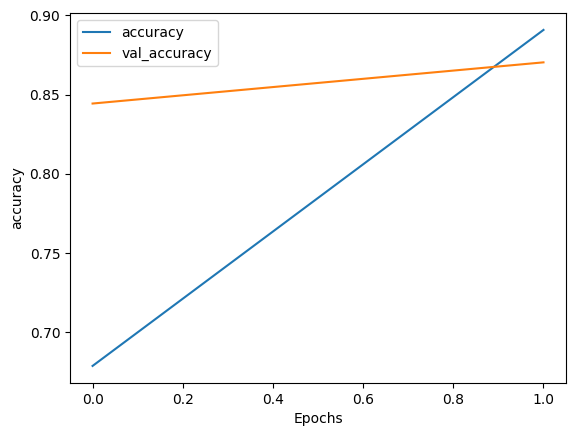

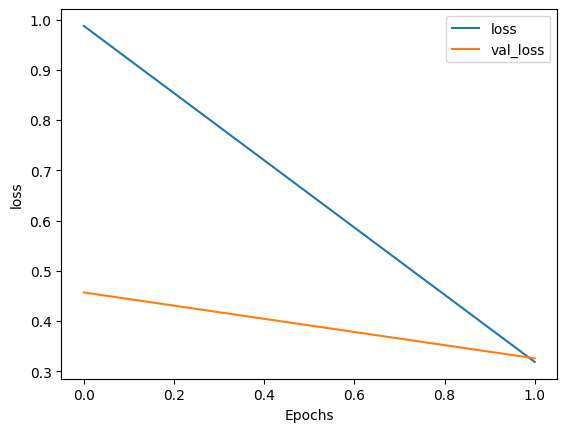

In [29]:
plot_history(history, "accuracy")
plot_history(history, "loss")

This code defines a helper function that plots a given metric (e.g., accuracy or loss) over the training epochs for both the training and validation sets.


The first graph shows that training accuracy increases rapidly, indicating the model is learning the training data effectively, while validation accuracy also rises steadily. The second graph demonstrates that training loss drops significantly and validation loss decreases at a gentler rate, suggesting the model is generalizing fairly well after only a couple of epochs.


### Evaluate the model

In [30]:
model.evaluate(testing_padded, testing_labels, verbose=2)

313/313 - 8s - 26ms/step - accuracy: 0.7669 - loss: 0.5415


[0.5415154099464417, 0.7669000029563904]

### Make predictions

In [45]:
sentences = ["I recently watched it, and it's absolutely fantastic. The acting, direction, and storytelling are all top-notch. I highly recommend it.",
             "I watched it and was let down. The acting felt flat, and the story was uninspiring. I wouldn't recommend it."]
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[[0.99728286]
 [0.3184046 ]]


seems to work

The model achieves about 76.9% accuracy on the test set with a loss of 0.54, indicating reasonably good performance in classifying unseen reviews. When asked to predict sentiment for two new sentences—one clearly positive and one clearly negative—the model outputs a high probability (around 0.98) for the positive review and a lower probability (around 0.31) for the negative review. This shows that the model is generally distinguishing positive and negative sentiments as intended.

### Visualizing the Embeddings

To visualize the embeddings we use this tool: https://projector.tensorflow.org/

This tool requires 2 inpiut file:
    
    * TSV file for the vectors
    * TSV file for metadata (optional)

In [32]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [35]:
#e = model.layers[0]
#weights = e.get_weights()[0]

IndexError: list index out of range

In [33]:
e = model.layers[1]
weights = e.get_weights()[0]

In [34]:
out_v = io.open('/content/vector.tsv', 'w', encoding='utf-8')
out_m = io.open('/content/metadata.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

In [38]:
out_v2 = io.open('/content/vector2.tsv', 'w', encoding='utf-8')
out_m2 = io.open('/content/metadata2.tsv', 'w', encoding='utf-8')

for word_num in range(vocab_size):  # Start from 0
    word = reverse_word_index.get(word_num, "<UNKNOWN>")  # Handle missing words
    embeddings = weights[word_num]
    out_m2.write(word + "\n")
    out_v2.write('\t'.join([str(x) for x in embeddings]) + "\n")


out_v2.close()
out_m2.close()

This code extracts the embedding weights from the model’s Embedding layer, then writes each word and its corresponding vector to two files, `metadata.tsv` and `vector.tsv`. This allows for external visualization or analysis of how the model represents each word.